## Hyperparam Tuning

In [33]:
#basic packages to operate and graph
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import warnings

import functions_variables as fv

#sklearn packages for model and pipeline opperation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import set_config
from sklearn.preprocessing import StandardScaler


#base settings 
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display="diagram")
X_dummy = pd.DataFrame()
source_folder_name = '../data'

 - Lets Load the dataset

In [2]:
# loading dataset 
X_train = pd.read_pickle("../data/processed/X_train.pkl")
y_train = pd.read_pickle("../data/processed/y_train.pkl")
X_test = pd.read_pickle("../data/processed/X_test.pkl")
y_test = pd.read_pickle("../data/processed/y_test.pkl")

- Defining our Paramater Grid we will use across the various models


In [3]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [50, 100, 150, 200]
}

- Testing our custom built cross validation search
    - model1


In [4]:
# Cross-Validation
train_folds, val_folds = fv.custom_cross_validation(X_train, y_train)

# Run Hyperparameter Search
best_hyperparams1 = fv.hyperparameter_search(train_folds, val_folds, param_grid)

# Print the best hyperparameters
print("Best Hyperparameters:", best_hyperparams1)


Best Hyperparameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 50}


- Test out our new model parameters

In [5]:
model1 = RandomForestRegressor(**best_hyperparams1, random_state=42)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
# Calculate evaluation metrics
rmse_model1, mae_model1, r2_model1 = fv.CalculateScores(y_pred, y_test)
model_metrics = {'model1_custom':{'rmse': rmse_model1, 'mae': mae_model1, 'r2': r2_model1}}


RMSE: 187344.19, MAE: 119445.70, R^2: 0.6526



## Hyperparam Tuning

 - Start with using GridSearchCV
    - model2

In [34]:


# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
best_hyperparams2 = grid_search.best_params_
print("Best Hyperparameters from GridSearchCV:", best_hyperparams2)


Best Hyperparameters from GridSearchCV: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


- Lets train a model based on the hyperparamters from GridSearchCV

In [7]:
model2 = RandomForestRegressor(**best_hyperparams2, random_state=42)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
rmse_model2, mae_model2, r2_model2 = fv.CalculateScores(y_pred, y_test)
model_metrics['model2_gridSearch'] = {'rmse': rmse_model2, 'mae': mae_model2, 'r2': r2_model2}


RMSE: 213569.43, MAE: 129529.91, R^2: 0.5485



- Lastly lets try out RandomizedSearchCV
    - model3

In [ ]:

# Initialize RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=100, cv=5, 
                                   scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)

# Perform RandomizedSearchCV on the training data
random_search.fit(X_train, y_train)

# Best hyperparameters found by RandomizedSearchCV
best_hyperparams3 = random_search.best_params_
print("Best Hyperparameters from RandomizedSearchCV:", best_hyperparams3)

Best Hyperparameters from RandomizedSearchCV: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


- Lets train a model based on those parameters and see how it compares

In [9]:
model3 = RandomForestRegressor(**best_hyperparams3, random_state=42)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
rmse_model3, mae_model3, r2_model3 = fv.CalculateScores(y_pred, y_test)
model_metrics['model3_randomSearch'] = {'rmse': rmse_model3, 'mae': mae_model3, 'r2': r2_model3}

RMSE: 212666.84, MAE: 124559.48, R^2: 0.5523



- Lets check out how our different tuning methods compare

In [10]:
metrics_df = pd.DataFrame(model_metrics)
metrics_df

,model1_custom,model2_gridSearch,model3_randomSearch
rmse,187344.187905,213569.431333,212666.840089
mae,119445.698217,129529.906959,124559.481727
r2,0.652591,0.548520,0.552328


- We're going to scale the data just so it can be seen a little nicer on our graph 

In [11]:
df = metrics_df.T
df['model'] = df.index
df = df.melt(id_vars=['model'],
        value_vars=['rmse','mae','r2'], 
        var_name='Metric',
          value_name='Score')
scalar = StandardScaler()
df[['Score_scaled']] = scalar.fit_transform(df[['Score']])

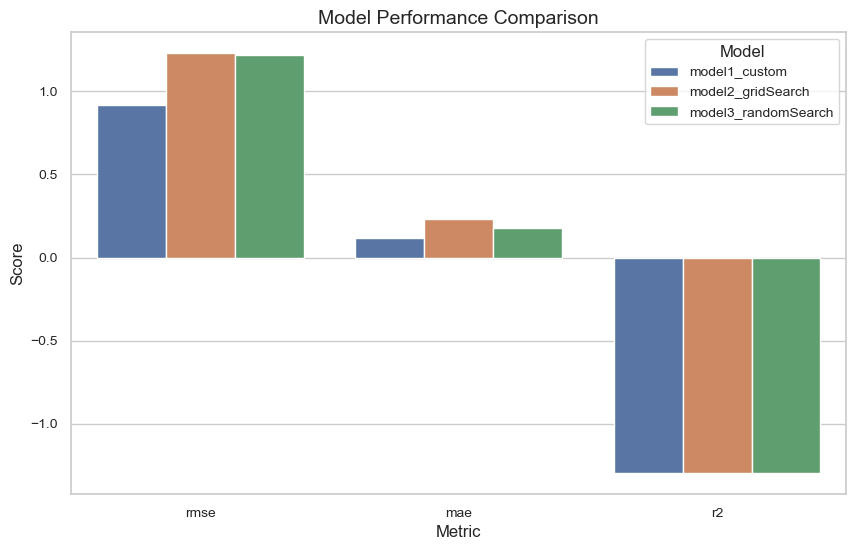

In [12]:
# Create the line plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
ax = sns.barplot(x="Metric", y="Score_scaled", hue="model", data=df)  # Adjust marker size if needed
plt.xlabel("Metric", fontsize=12)  # Increase font size
plt.ylabel("Score", fontsize=12)
plt.title("Model Performance Comparison", fontsize=14)
plt.xticks(fontsize=10)  # Increase tick font size
plt.yticks(fontsize=10)
plt.legend(title="Model", fontsize=10)  # Increase legend font size


plt.show()

In [13]:
print(f"model1_custom:\n{best_hyperparams1}\n\nmodel2_gridSearch:\n{best_hyperparams2}\n\nmodel3_randomSearch:\n {best_hyperparams3}")

model1_custom:
{'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 50}

model2_gridSearch:
{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}

model3_randomSearch:
 {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}


- We're actually seeing the best results from our custom built search grid, so we're going to run with that one for our best model

### Lastly we will Save our model

In [14]:
# Save your best model here
best_model = model1
filename = 'best_model.pkl'
model_dir = '../data/models'
filepath = os.path.join(model_dir, filename)

# Save model using pickle
try:
    with open(filepath, 'wb') as file:
        pickle.dump(best_model, file)
        print(f"Model saved to: {filepath}")
except Exception as e:
    print(f"Error saving model to {filepath}: {e}")

Model saved to: ../data/models\best_model.pkl


## Building a Pipeline (Stretch)

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it if you have time!**

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

### Create the Classes for the loading and cleaning of the data
    - this could have been done by a Function Transformer however I wanted the practice at writing classes
        - code for the FunctionTransformer would have been much simpler

In [15]:
loader = fv.DataLoader(source_folder_name)
loader

In [16]:
cleaner = fv.DataCleaner(num_type_to_drop=20)
cleaner

### Create seperate classes to scale the numeric values with a StandardScalar and the Boolean Values using PCA to reduce the amount of columns
    - again fairly unneccesary currently this was mostly an exercise in building more complex classes and strining them into a union

In [17]:
pca = fv.PCA_bool(n_components=10)
pca

In [18]:
scalar = fv.Scalar_numeric()
scalar

In [19]:
rf = RandomForestRegressor(**best_hyperparams1, random_state=42)
rf

RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=50, random_state=42)

### Build our basic pipelines, one to load and clean the data, the next to scale and learn from the data
        - the load and clean pipeline is just stringing two basic functions together so there is no real need for it as a solo pipeline however if I want the flexibility to have a train/test/split in there I cannot tie the load/clean pipe onto the processing pipe.

In [20]:
# Build pipeline here

pipe_load_clean = Pipeline([
    ('loader', loader),
    ('cleaner', cleaner)
])

union_pipe = FeatureUnion(transformer_list=[
    ('numeric', scalar),
    ('boolean', pca)
])

processing_pipe = Pipeline([
    ('scaling_union', union_pipe),
    ('random_forest', rf)
])

In [21]:
cleaned_data = pipe_load_clean.fit_transform(X_dummy)
pipe_load_clean

Not a Json: .gitkeep
Not a Json: license.txt
Not a Json: models
Not a Json: processed
Not a Json: uscities.csv
Geocoding attempt 1 of 4...
Error geocoding Providence, Rhode Island: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Providence%2C+Rhode+Island%2C+downtown&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Nashville, Tennessee: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Nashville%2C+Tennessee%2C+downtown&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error geocoding Albany, New York: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Albany%2C+New+York%2C+downtown&format=json&li

Pipeline(steps=[('loader',
                 <functions_variables.DataLoader object at 0x000002E06231C610>),
                ('cleaner',
                 <functions_variables.DataCleaner object at 0x000002E061AFAA90>)])

In [25]:
processing_pipe

Pipeline(steps=[('scaling_union',
                 FeatureUnion(transformer_list=[('numeric',
                                                 <functions_variables.Scalar_numeric object at 0x000002E061A3F640>),
                                                ('boolean',
                                                 <functions_variables.PCA_bool object at 0x000002E06231C790>)])),
                ('random_forest',
                 RandomForestRegressor(max_depth=20, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=50, random_state=42))])

In [26]:
X = cleaned_data.drop('sold_price', axis=1)
y = cleaned_data['sold_price']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.8, random_state=42)


model = processing_pipe.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse, mae, r2 = fv.CalculateScores(y_pred, y_test)

RMSE: 230389.76, MAE: 126727.57, R^2: 0.4746



In [27]:
print('rmse:', rmse,'\nmae:', mae, '\nr2:',r2)

rmse: 230389.75530521487 
mae: 126727.57398567669 
r2: 0.47460406377197417


Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

 - We can create a complete load-completion pipeline for this, it will just lack the flexibility of validation

- Lets train that model and save it

In [32]:
model_dir = '../data/models'
filename = 'best_pipeline.pkl'

filepath = os.path.join(model_dir, filename)

os.makedirs(model_dir, exist_ok=True) #makes directory if it does not exsist

try:
    with open(filepath, 'wb') as file:
        pickle.dump(processing_pipe, file)
        print(f"Model saved to {filepath}")
except Exception as e:
    print(f"Error saving model: {e}")


Model saved to ../data/models\best_pipeline.pkl
